## Backorder Prediction

After Data prep, Business Problem to remember:

Cost are as following: The company sells 1,000 units on average per month at a price of dollar 60 per unit (avg cost). The cost of of warehousing and maintaining these units is dollar 10 per unit per month (avg cost)

In [1]:
#pip install imbalanced-learn

### Import and install python libraries 

In [2]:
# import numpy and pandas libraries
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score ,f1_score,classification_report, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")


np.random.seed(113)

### Load data
Load data (it's already cleaned and preprocessed)

In [3]:
X_train = pd.read_csv("bop_X_train.csv")
X_test = pd.read_csv("bop_X_test.csv")
y_train = pd.read_csv("bop_y_train.csv")
y_test = pd.read_csv("bop_y_test.csv")

#### Performance Evaluation Parameter to be considered:
In the case of Backorders, it happens very rarely that the products goes to backorder. So in this type of problems , Accuracy is not a useful metric since it works well with Balanced dataset.
Since the dataset is imbalanced, the ideal performance metric would be Precision, Recall and F1 score , especially not to miss failure cases.

True Positive: The product was detected as being on backorder and it turned out to be True. Profit generated from such items is a benefit of correctly predicting backorders.

True Negative: The product was detected as not being on backorder, and it turned out to be true. We will not be generating extra and we will save on manufacturing and inventory. 

False Positive: Product detected as Backorder when it is not. This would cost the company because we predicted a few items as Backorder items but they were not on the list. The cost of warehousing for such items is the cost of false positives.
The cost of warehousing and maintaining these units is dollar 10 per unit per month, the total cost of false positives for 100 units would be dollar 1000 per month.

False Negative: The model fails to detect the product, and it remains as Non-Backorder. This will cost the company money due to the cost of incorrectly missing items when there was a demand for them.
The company sells at a price of dollar 60 per unit, and the model fails to predict that 100 units will go on backorder, the company may lose potential sales revenue of dollar 6,000 from these missed sales.

F1 Score might be a better measure to use if we need to seek balance between Precision and Recall and also given that there is uneven class distribution(large number of Actual Negatives).
F1 Score will be used when False Positives and False Negatives are more important as they are crucial for Business cost.

In [4]:
performance = pd.DataFrame({"model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1": []})

### Logistic Regression
#### Logistic Regression Random Search CV using default, L1, L2, Elastic, liblinear regularization
Conduct an initial random search across a wide range of possible parameters.

In [6]:
score_measure = "f1"
kfolds = 3

param_grid = {
    'max_iter':np.arange(200,500),
    'penalty': ['None','l1','l2','elasticnet'],
    'solver':['saga','liblinear']
}

log_reg_model = LogisticRegression()
rand_search = RandomizedSearchCV(estimator = log_reg_model, param_distributions=param_grid, cv=kfolds, n_iter=250,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 3 folds for each of 250 candidates, totalling 750 fits
The best f1 score is 0.7674602572813537
... with parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 313}


#### Logistic Regression Grid Search CV using default, L1, L2, Elastic, liblinear regularization
Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [7]:
score_measure = "f1"
kfolds = 3
max_iter = rand_search.best_params_['max_iter']
penalty = rand_search.best_params_['penalty']
solver = rand_search.best_params_['solver']

param_grid = {
    'max_iter': np.arange(max_iter-5,max_iter+5),  
    'penalty': [penalty],
    'solver': [solver]
}

log_reg_model = LogisticRegression()
grid_search = GridSearchCV(estimator = log_reg_model, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallLogistic = grid_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
The best f1 score is 0.7674602572813537
... with parameters: {'max_iter': 309, 'penalty': 'l1', 'solver': 'liblinear'}


In [8]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Logistic Regression", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### Support Vector Machine
#### SVM Random Search CV using linear, rbf and poly kernal
Conduct an initial random search across a wide range of possible parameters.

In [9]:
score_measure = "f1"
kfolds = 3

param_grid = {
    'C': np.arange(1,25),   
    'gamma': ['scale','auto'],
    'kernel':['linear','rbf','poly']
}

svm_model = SVC()
rand_search = RandomizedSearchCV(estimator = svm_model, param_distributions=param_grid, cv=kfolds, n_iter=250,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits
The best f1 score is 0.7271757605646744
... with parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 24}


#### SVM Grid Search CV using linear, rbf and poly kernal
Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [10]:
score_measure = "f1"
kfolds = 3

C = rand_search.best_params_['C']
gamma = rand_search.best_params_['gamma']
kernel = rand_search.best_params_['kernel']

param_grid = {
    'C': np.arange(C-2,C+2),  
    'gamma': [gamma],
    'kernel': [kernel]
    
}

svm_model = SVC()
grid_search = GridSearchCV(estimator = svm_model, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallSVM = grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
The best f1 score is 0.7279372001699901
... with parameters: {'C': 25, 'gamma': 'scale', 'kernel': 'rbf'}


In [11]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"SVM", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

### Decision Tree Classifer
#### DTree Random Search CV
Conduct an initial random search across a wide range of possible parameters.

In [12]:
score_measure = "f1"
kfolds = 3

param_grid = {
    'min_samples_split': np.arange(1,100),  
    'min_samples_leaf': np.arange(1,100),
    'min_impurity_decrease': np.arange(0.0001, 0.01, 0.0005),
    'max_leaf_nodes': np.arange(5, 100), 
    'max_depth': np.arange(1,50), 
    'criterion': ['entropy', 'gini'],
}

dtree = DecisionTreeClassifier()
rand_search = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=250,
                           scoring=score_measure, verbose=1, n_jobs=-1, 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

Fitting 3 folds for each of 250 candidates, totalling 750 fits
The best f1 score is 0.867351841484867
... with parameters: {'min_samples_split': 43, 'min_samples_leaf': 9, 'min_impurity_decrease': 0.0006000000000000001, 'max_leaf_nodes': 71, 'max_depth': 24, 'criterion': 'gini'}


#### DTree Grid Search CV
Conduct an exhaustive search across a smaller range of parameters around the parameters found in the initial random search.

In [13]:
score_measure = "f1"
kfolds = 3
min_samples_split = rand_search.best_params_['min_samples_split']
min_samples_leaf = rand_search.best_params_['min_samples_leaf']
min_impurity_decrease = rand_search.best_params_['min_impurity_decrease']
max_leaf_nodes = rand_search.best_params_['max_leaf_nodes']
max_depth = rand_search.best_params_['max_depth']
criterion = rand_search.best_params_['criterion']

param_grid = {
    'min_samples_split': np.arange(min_samples_split-2,min_samples_split+2),  
    'min_samples_leaf': np.arange(min_samples_leaf-2,min_samples_leaf+2),
    'min_impurity_decrease': np.arange(min_impurity_decrease-0.0001, min_impurity_decrease+0.0001, 0.00005),
    'max_leaf_nodes': np.arange(max_leaf_nodes-2,max_leaf_nodes+2), 
    'max_depth': np.arange(max_depth-2,max_depth+2), 
    'criterion': [criterion]
}

dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid=param_grid, cv=kfolds, 
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = grid_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {grid_search.best_score_}")
print(f"... with parameters: {grid_search.best_params_}")

bestRecallTree = grid_search.best_estimator_

Fitting 3 folds for each of 1280 candidates, totalling 3840 fits
The best f1 score is 0.8689860758364657
... with parameters: {'criterion': 'gini', 'max_depth': 22, 'max_leaf_nodes': 69, 'min_impurity_decrease': 0.0006000000000000001, 'min_samples_leaf': 7, 'min_samples_split': 41}


In [14]:
c_matrix = confusion_matrix(y_test, grid_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
performance = pd.concat([performance, pd.DataFrame({'model':"Decision Tree", 
                                                    'Accuracy': [(TP+TN)/(TP+TN+FP+FN)], 
                                                    'Precision': [TP/(TP+FP)], 
                                                    'Recall': [TP/(TP+FN)], 
                                                    'F1': [2*TP/(2*TP+FP+FN)]
                                                     }, index=[0])])

#### Diagrams of the Dtree:

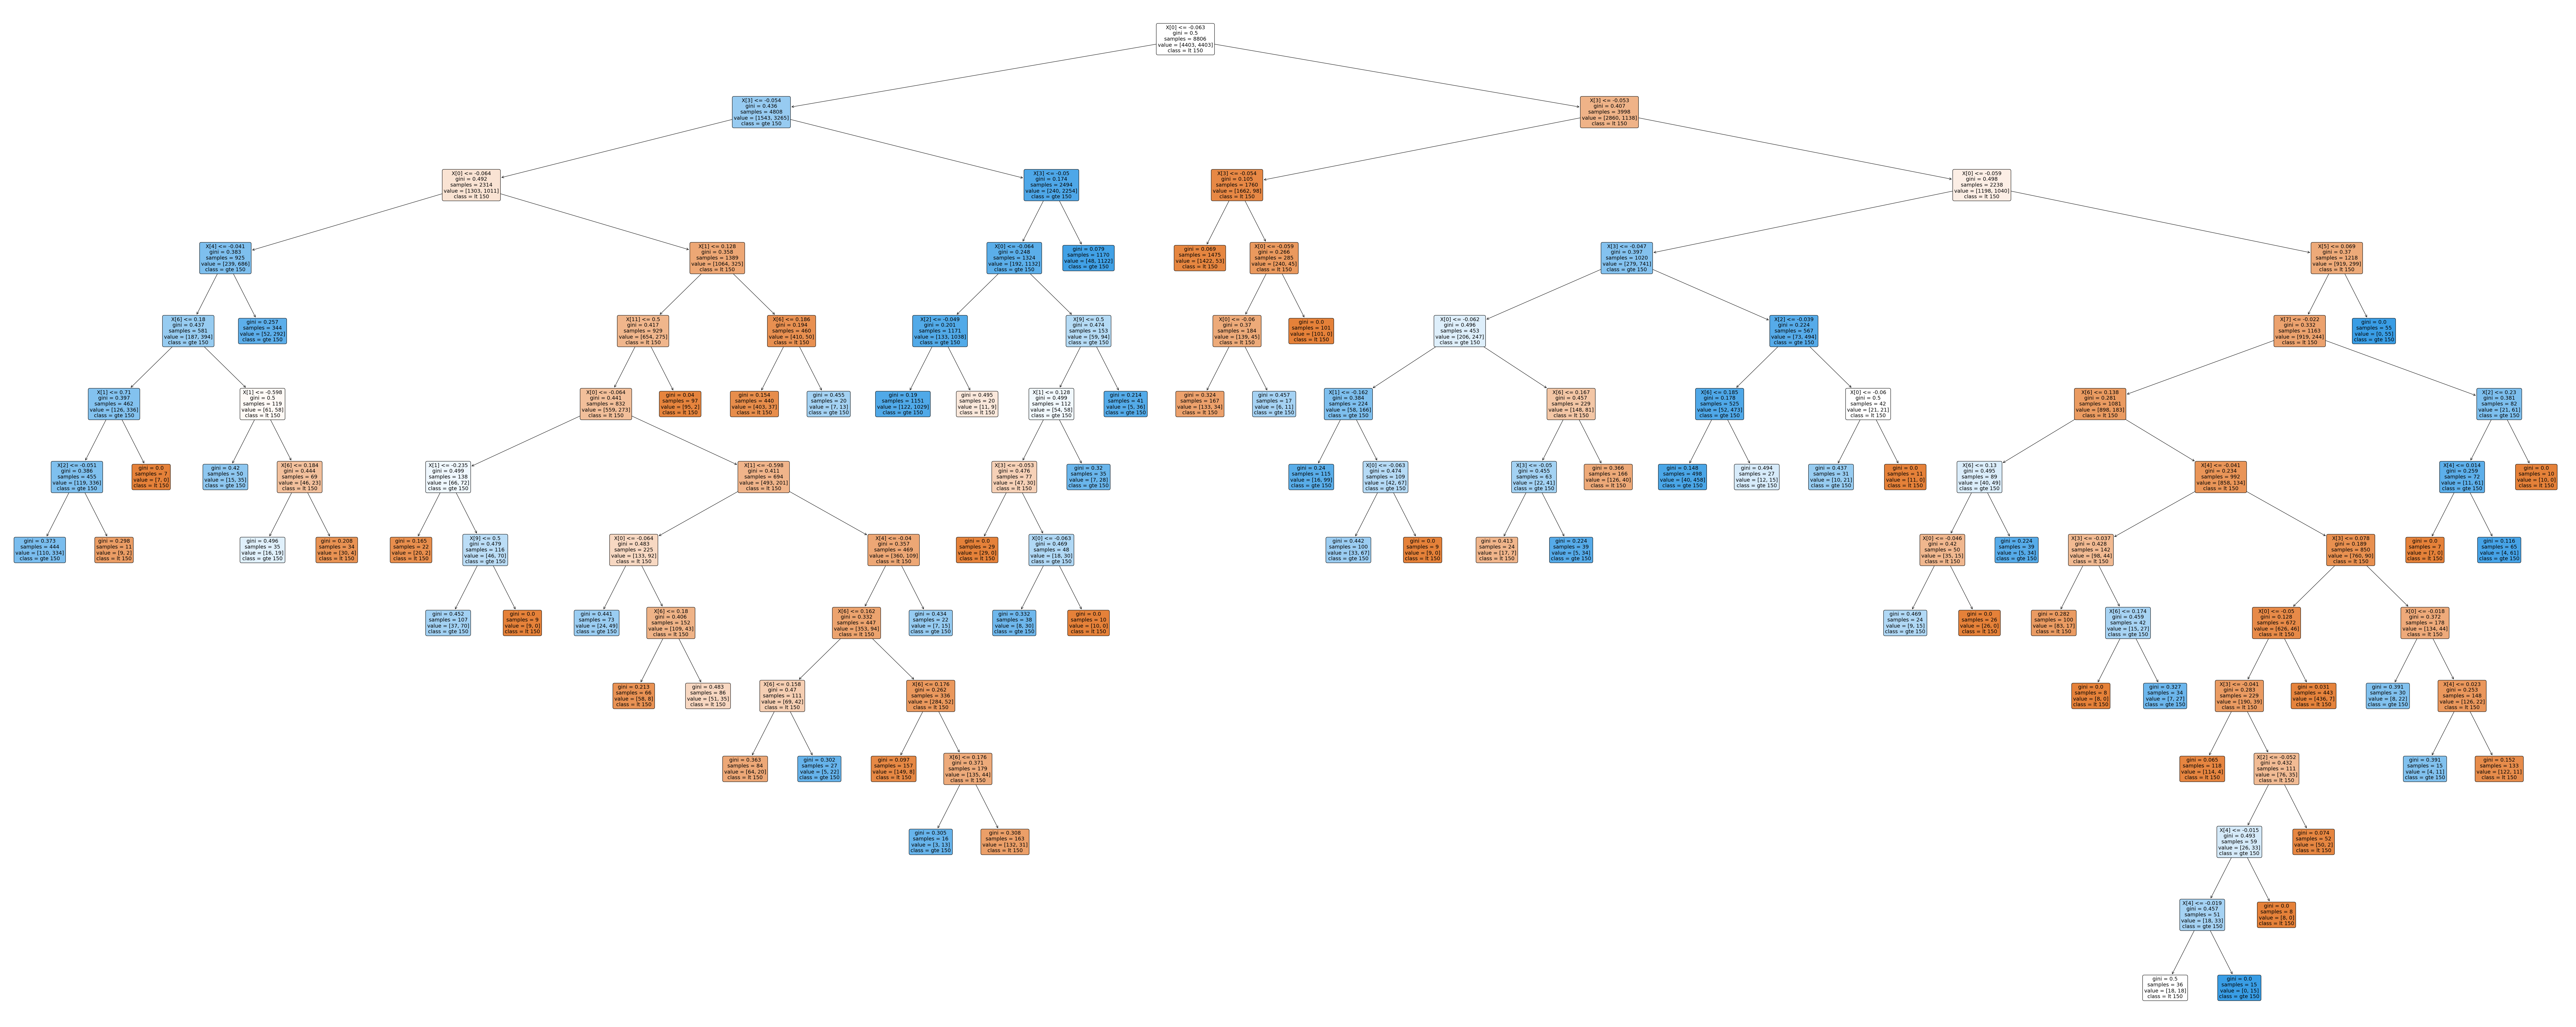

In [15]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(125,50))
tree = plot_tree(grid_search.best_estimator_,
              class_names=['lt 150', 'gte 150'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

### Summary of the models
Sorted by F1, the best models are:

In [17]:
performance.sort_values(by=['F1'])

,model,Accuracy,Precision,Recall,F1
0,SVM,0.547995,0.351841,0.9328,0.510955
0,Logistic Regression,0.666667,0.426449,0.9184,0.582445
0,Decision Tree,0.859862,0.667467,0.8896,0.762689


F1 value has been taken here in consideration to give FN and FP have been given equal weightage.

As per the above matrix, the best performance is of the Decision Tree with 76.26% F1 score. The Logistic Regression and SVM has F1 value of 58.24% and 51.09% respectively. 

### Business Evaluation

Let us compare the phenomenon the cost that would cost a company if the modelling 


For every false positive prediction (product detected as backorder but it is not), the company incurs a cost of dollar 10 for excess inventory and warehousing.

For every false negative prediction (product not detected as backorder but it is), the company incurs a cost of dollar 60 in lost sales revenue per unit.

##### Without Modelling Approach:
Without a modeling approach, the company experiences 200 false positives and 50 false negatives for every 1000 predictions made.
Using the cost estimates, the cost of false positives would be 200 x 10 dollars = 2000 dollars while the cost of false negatives would be 25 x 60 = 1500 dollars. This would result in a total cost of 3500 dollars for every 1000 predictions made.



##### With Modelling Approach:
If the company used a modeling approach with an F1 score of 0.76 the cost of false positives would be 56 x dollars 10 = 560 dollars, and the cost of false negatives would be reduced to 7 x 60 = 420 dollars. This would result in a total cost of dollar 980 for every 1000 predictions made.

##### Should we use the model?
By using a modeling approach with an optimized F1 score, the company could potentially save dollar 2520 for every 1000 predictions made, compared to relying on manual methods without a modeling approach.

As backorders can upset consumers, lead to canceled orders and decreased customer loyalty, the manufacturing company can use the modelling technique not only to avoid backorders, but also avoid overstocking every product (leading to higher inventory costs).
